In [ ]:

import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')

# -------------------------------
# 1. Read all quarterly datasets for years 2015–2024 with yearly caching
# -------------------------------
base_dir = "/content/drive/My Drive/datasets"
cache_dir = "/content/drive/My Drive/faers_cache"
os.makedirs(cache_dir, exist_ok=True)

years = range(2015, 2025)
quarters = ["Q1", "Q2", "Q3", "Q4"]

def safe_read_csv(file_path, sep='$', usecols=None, chunksize=100000):
    chunks = []
    try:
        for chunk in pd.read_csv(file_path, sep=sep, chunksize=chunksize, low_memory=False, usecols=usecols):
            chunks.append(chunk)
        return pd.concat(chunks, ignore_index=True)
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return pd.DataFrame()

for year in years:
    year_drug, year_demo, year_reac, year_indi = [], [], [], []
    for quarter in quarters:
        folder_name = f"faers_{year}{quarter}"
        folder_path = os.path.join(base_dir, folder_name)
        if not os.path.isdir(folder_path):
            continue

        year_str = str(year)[2:]
        suffix = f"{year_str}{quarter}"
        drug_file = os.path.join(folder_path, f"DRUG{suffix}.txt")
        demo_file = os.path.join(folder_path, f"DEMO{suffix}.txt")
        reac_file = os.path.join(folder_path, f"REAC{suffix}.txt")
        indi_file = os.path.join(folder_path, f"INDI{suffix}.txt")

        if os.path.isfile(drug_file):
            df = safe_read_csv(drug_file)
            df['year'], df['quarter'] = year, quarter
            year_drug.append(df)

        if os.path.isfile(demo_file):
            df = safe_read_csv(demo_file)
            df['year'], df['quarter'] = year, quarter
            year_demo.append(df)

        if os.path.isfile(reac_file):
            df = safe_read_csv(reac_file)
            df['year'], df['quarter'] = year, quarter
            year_reac.append(df)

        if os.path.isfile(indi_file):
            df = safe_read_csv(indi_file)
            df['year'], df['quarter'] = year, quarter
            year_indi.append(df)

    # Save yearly data to cache
    if year_drug:
        pd.concat(year_drug, ignore_index=True).to_parquet(os.path.join(cache_dir, f"drug_{year}.parquet"))
    if year_demo:
        pd.concat(year_demo, ignore_index=True).to_parquet(os.path.join(cache_dir, f"demo_{year}.parquet"))
    if year_reac:
        pd.concat(year_reac, ignore_index=True).to_parquet(os.path.join(cache_dir, f"reac_{year}.parquet"))
    if year_indi:
        pd.concat(year_indi, ignore_index=True).to_parquet(os.path.join(cache_dir, f"indi_{year}.parquet"))


In [ ]:

# -------------------------------
# 2. Load cached yearly data
# -------------------------------
import glob

drug_files = sorted(glob.glob(os.path.join(cache_dir, "drug_*.parquet")))
demo_files = sorted(glob.glob(os.path.join(cache_dir, "demo_*.parquet")))
reac_files = sorted(glob.glob(os.path.join(cache_dir, "reac_*.parquet")))
indi_files = sorted(glob.glob(os.path.join(cache_dir, "indi_*.parquet")))

drug_df = pd.concat([pd.read_parquet(f) for f in drug_files], ignore_index=True)
demo_df = pd.concat([pd.read_parquet(f) for f in demo_files], ignore_index=True)
reac_df = pd.concat([pd.read_parquet(f) for f in reac_files], ignore_index=True)
indi_df = pd.concat([pd.read_parquet(f) for f in indi_files], ignore_index=True)

print("Loaded full drug_df shape:", drug_df.shape)
print("Loaded full demo_df shape:", demo_df.shape)
print("Loaded full reac_df shape:", reac_df.shape)
print("Loaded full indi_df shape:", indi_df.shape)


In [ ]:
print(drug_df.head())
print(demo_df.head())
print(reac_df.head())
print(indi_df.head())

   primaryid    caseid  drug_seq role_cod     drugname  \
0  100046573  10004657         1       PS      LIPITOR   
1  100046573  10004657         2        C    TOPROL XL   
2  100046962  10004696         1       PS  QUETIAPINE.   
3  100046962  10004696         2        I   CITALOPRAM   
4  100046962  10004696         3        I   CITALOPRAM   

                   prod_ai  val_vbm    route    dose_vbm  cum_dose_chr  ...  \
0     ATORVASTATIN CALCIUM        1     Oral  40 MG, UNK           NaN  ...   
1     METOPROLOL SUCCINATE        1      NaN         UNK           NaN  ...   
2               QUETIAPINE        1  Unknown      500 MG           NaN  ...   
3  CITALOPRAM HYDROBROMIDE        1  Unknown       10 MG           NaN  ...   
4  CITALOPRAM HYDROBROMIDE        1      NaN         NaN           NaN  ...   

  rechal lot_num exp_dt  nda_num dose_amt dose_unit           dose_form  \
0    NaN     NaN    NaN  20702.0     40.0        MG  FILM-COATED TABLET   
1    NaN     NaN    NaN   

In [ ]:
# 2. Filter for Prednisolone records and classify them into 5 categories
drug_df['drugname_clean'] = drug_df['drugname'].str.upper().fillna("")
prednisolone_drugs = drug_df[drug_df['drugname_clean'].str.contains("PREDNISOLONE", na=False)]
prednisolone_df = prednisolone_drugs.copy()

def classify_pred_methyl_5cat(drugname):
    """
    Classify drug names into 5 categories:
    1) PREDNISOLONE (base)
    2) PREDNISOLONE_DERIVATIVE
    3) METHYLPREDNISOLONE (base)
    4) METHYLPREDNISOLONE_DERIVATIVE
    5) COMBINATION (if multiple active ingredients are present)
    """
    name = drugname.upper()
    if re.search(r'[\\/;]', name):
        return "COMBINATION"
    if "METHYLPREDNISOLONE" in name:
        if any(x in name for x in ["ACETATE", "PHOSPHATE", "SUCCINATE", "ACEPONATE", "HEMISUCCINATE"]):
            return "METHYLPREDNISOLONE_DERIVATIVE"
        else:
            return "METHYLPREDNISOLONE"
    elif "PREDNISOLONE" in name:
        if any(x in name for x in ["ACETATE", "PHOSPHATE", "STEAGLATE", "VALERATE", "SUCCINATE", "METASULFO", "METAZOATE"]):
            return "PREDNISOLONE_DERIVATIVE"
        else:
            return "PREDNISOLONE"
    else:
        return np.nan

prednisolone_df['major_class_5cat'] = prednisolone_df['drugname_clean'].apply(classify_pred_methyl_5cat)
print("Classification counts (5 categories):")
print(prednisolone_df['major_class_5cat'].value_counts(dropna=False))



Classification counts (5 categories):
major_class_5cat
PREDNISOLONE                     36817
METHYLPREDNISOLONE               26133
METHYLPREDNISOLONE_DERIVATIVE     7507
PREDNISOLONE_DERIVATIVE           2034
COMBINATION                        238
Name: count, dtype: int64


In [ ]:
# -------------------------------
# 3. Merge with DEMO, REAC, and INDI datasets based on caseid
# -------------------------------
caseids = prednisolone_df['caseid'].unique()

demo_keep = ['primaryid', 'caseid', 'year', 'quarter', 'age', 'sex']
reac_keep = ['primaryid', 'caseid', 'year', 'quarter', 'pt']
indi_keep = ['primaryid', 'caseid', 'year', 'quarter', 'indi_pt']
pred_keep = ['primaryid', 'caseid', 'year', 'quarter', 'drug_seq', 'role_cod', 'drugname', 'drugname_clean', 'major_class_5cat', 'dechal', 'rechal']


demo_sub = demo_df[demo_df['caseid'].isin(caseids)][demo_keep]
reac_sub = reac_df[reac_df['caseid'].isin(caseids)][reac_keep]
indi_sub = indi_df[indi_df['caseid'].isin(caseids)][indi_keep]
pred_sub = prednisolone_df[pred_keep]

merged_demo_drug = pd.merge(demo_sub, pred_sub, on=['primaryid','caseid','year','quarter'], how='left')
merged_drug_reac = pd.merge(merged_demo_drug, reac_sub, on=['primaryid','caseid','year','quarter'], how='left')
final_merged = pd.merge(merged_drug_reac, indi_sub, on=['primaryid','caseid','year','quarter'], how='left')

print("Final merged DataFrame shape:", final_merged.shape)
print(final_merged.head(10))



Final merged DataFrame shape: (23481736, 15)
    primaryid    caseid  year quarter   age sex  drug_seq role_cod  \
0  1005528543  10055285  2020      Q4  57.0   F      33.0        C   
1  1005528543  10055285  2020      Q4  57.0   F      33.0        C   
2  1005528543  10055285  2020      Q4  57.0   F      33.0        C   
3  1005528543  10055285  2020      Q4  57.0   F      33.0        C   
4  1005528543  10055285  2020      Q4  57.0   F      33.0        C   
5  1005528543  10055285  2020      Q4  57.0   F      33.0        C   
6  1005528543  10055285  2020      Q4  57.0   F      33.0        C   
7  1005528543  10055285  2020      Q4  57.0   F      33.0        C   
8  1005528543  10055285  2020      Q4  57.0   F      33.0        C   
9  1005528543  10055285  2020      Q4  57.0   F      33.0        C   

        drugname drugname_clean major_class_5cat dechal rechal  \
0  PREDNISOLONE.  PREDNISOLONE.     PREDNISOLONE      U    NaN   
1  PREDNISOLONE.  PREDNISOLONE.     PREDNISOLONE    

In [ ]:
# -------------------------------
# 4. Aggregate records: one row per (year, quarter, caseid)
# -------------------------------
def join_unique(x):
    return "; ".join(sorted(set(x.dropna())))

final_one_row = final_merged.groupby(['year','quarter','caseid'], as_index=False).agg({
    'age': 'first',
    'sex': 'first',
    'drugname_clean': 'first',
    'major_class_5cat': 'first',
    'pt': join_unique,
    'indi_pt': join_unique,
    'dechal': 'first',
    'rechal': 'first'
})

print("Aggregated DataFrame shape:", final_one_row.shape)
print(final_one_row.head(10))

# -------------------------------
# 5. Create additional variable: Age Group
# -------------------------------
bins = [0, 18, 35, 50, 65, 100]
labels = ['0-18', '18-35', '35-50', '50-65', '65+']
final_one_row['age_group'] = pd.cut(final_one_row['age'], bins=bins, labels=labels)

# -------------------------------
# 6. Explode the 'pt' column (adverse events) for detailed mapping
# -------------------------------
# Assume 'pt' is a string with adverse events separated by "; "
final_one_row['pt_list'] = final_one_row['pt'].str.split("; ")
exploded_df = final_one_row.explode('pt_list')



Aggregated DataFrame shape: (45580, 11)
   year quarter   caseid   age sex       drugname_clean    major_class_5cat  \
0  2020      Q4  6715981  37.0   M        PREDNISOLONE.        PREDNISOLONE   
1  2020      Q4  6798099  44.0   M        PREDNISOLONE.        PREDNISOLONE   
2  2020      Q4  7096069  45.0   M        PREDNISOLONE.        PREDNISOLONE   
3  2020      Q4  7740732  30.0   F  METHYLPREDNISOLONE.  METHYLPREDNISOLONE   
4  2020      Q4  7796415  64.0   M  METHYLPREDNISOLONE.  METHYLPREDNISOLONE   
5  2020      Q4  7928220  63.0   F        PREDNISOLONE.        PREDNISOLONE   
6  2020      Q4  8220672  68.0   M        PREDNISOLONE.        PREDNISOLONE   
7  2020      Q4  8221889  68.0   M        PREDNISOLONE.        PREDNISOLONE   
8  2020      Q4  8497662  67.0   F  METHYLPREDNISOLONE.  METHYLPREDNISOLONE   
9  2020      Q4  8671723  60.0   F  METHYLPREDNISOLONE.  METHYLPREDNISOLONE   

                                                  pt  \
0                                 

<ipython-input-43-6028be72f231>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='year', y='report_count', data=yearly_counts, palette="Blues_d")


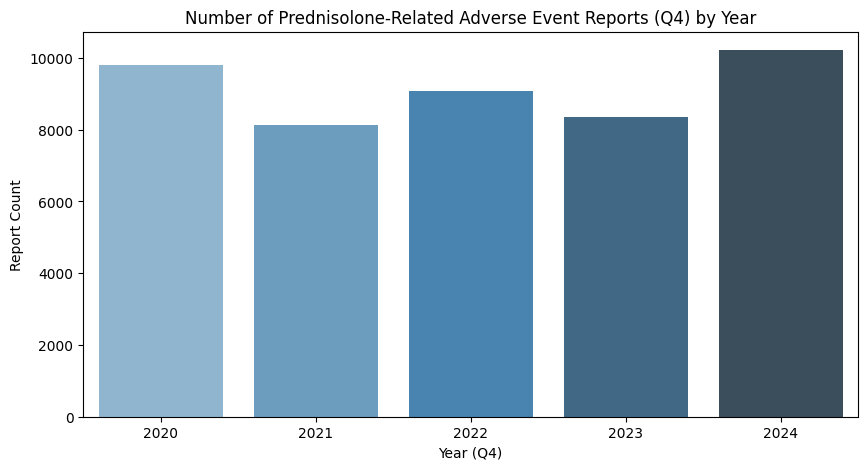

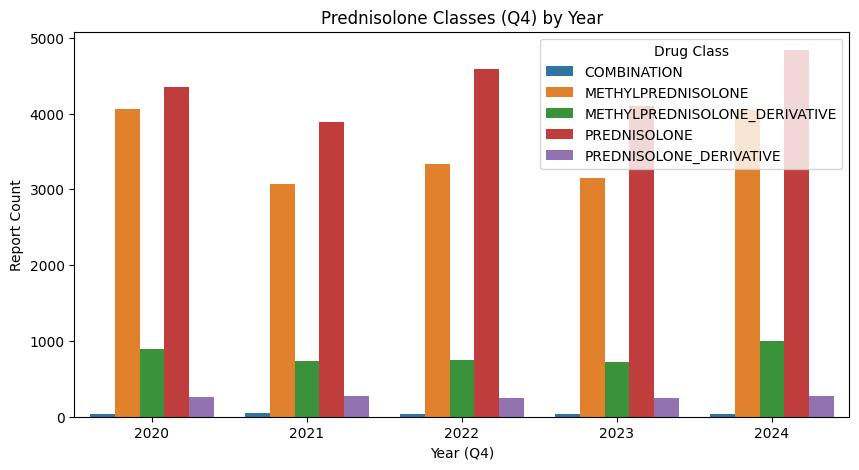

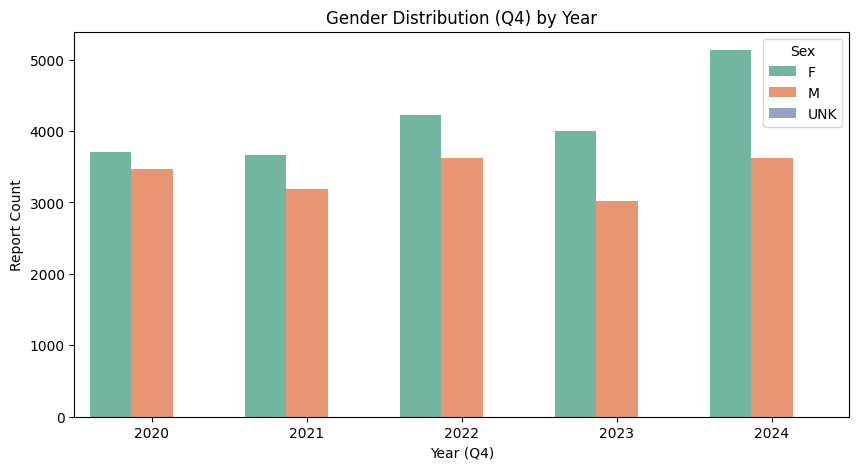

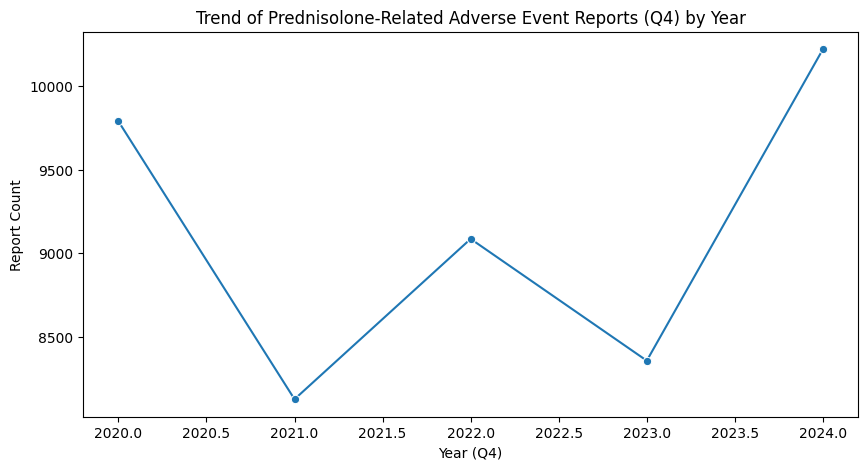

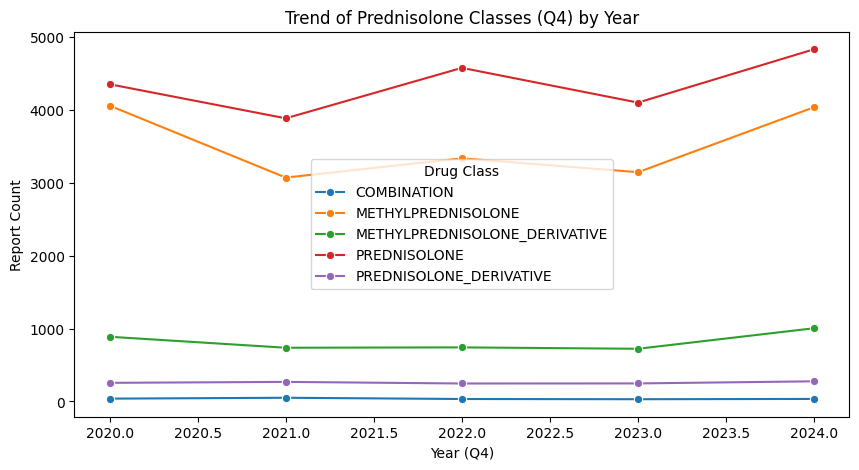

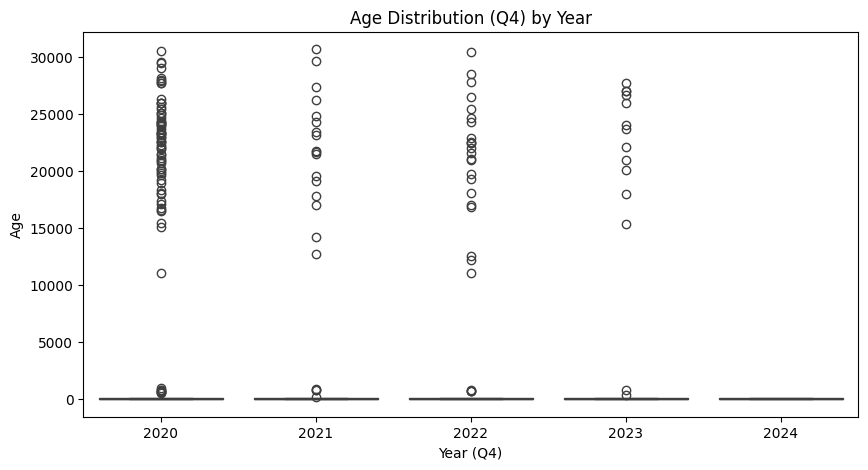

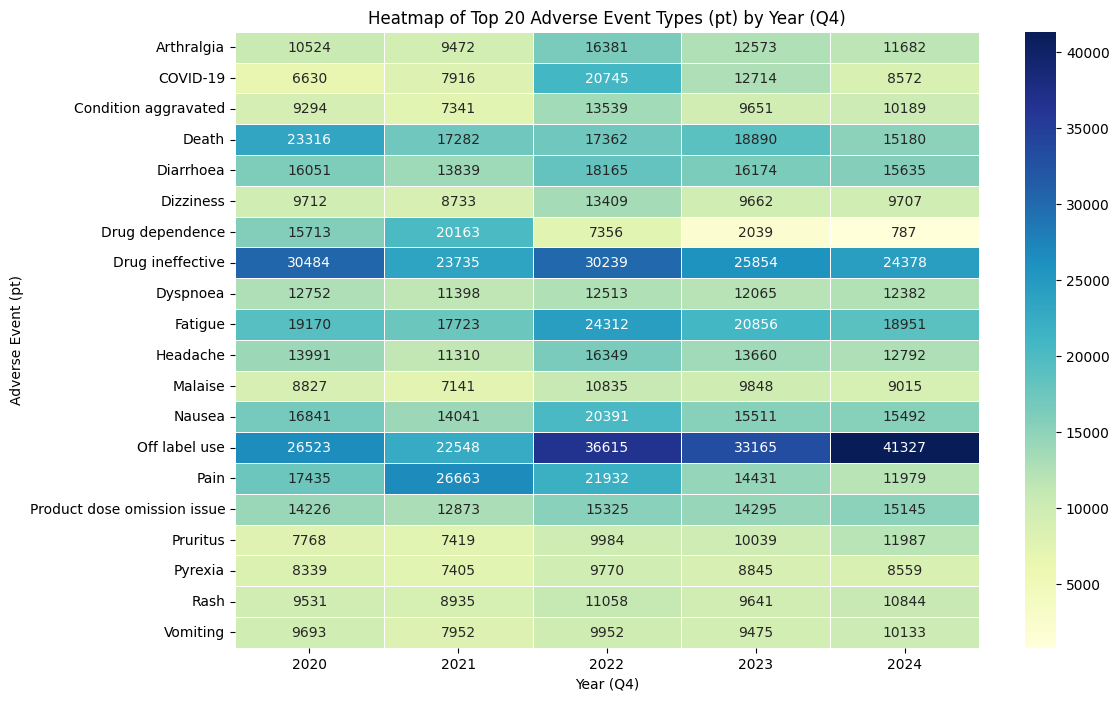

<ipython-input-43-6028be72f231>:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  class_age_pivot = exploded_df.groupby(['major_class_5cat', 'age_group']).size().reset_index(name='count')


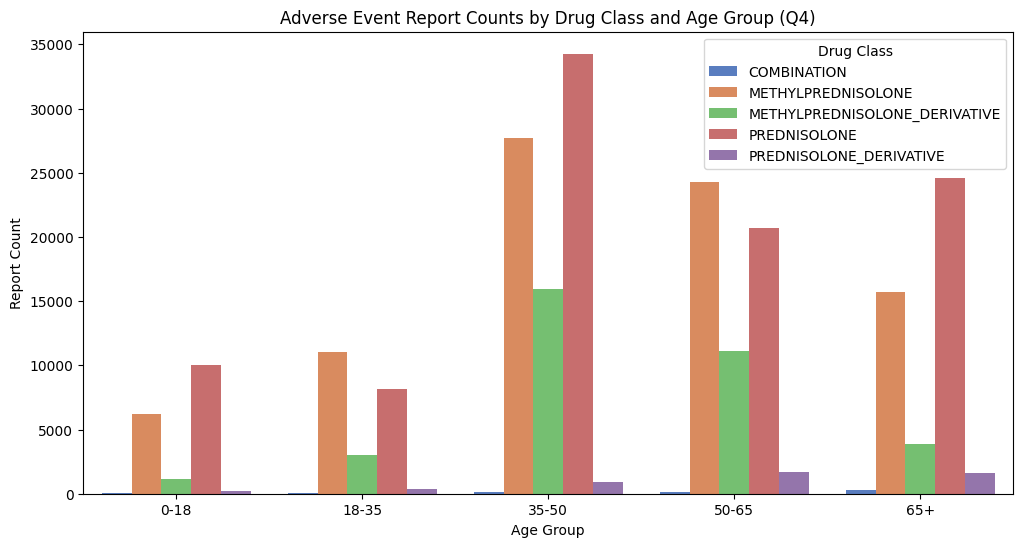

Visualizations for Q4 data (2020–2024) have been generated.


In [ ]:
# -------------------------------
# 7. Visualization
# -------------------------------

# (a) Bar Plot: Total number of adverse event reports by year (Q4)
yearly_counts = final_one_row.groupby('year').size().reset_index(name='report_count')
plt.figure(figsize=(10, 5))
sns.barplot(x='year', y='report_count', data=yearly_counts, palette="Blues_d")
plt.title("Number of Prednisolone-Related Adverse Event Reports (Q4) by Year")
plt.xlabel("Year (Q4)")
plt.ylabel("Report Count")
plt.show()

# (b) Bar Plot: Distribution of the 5 drug classes across years (Q4)
class_year_counts = final_one_row.groupby(['year', 'major_class_5cat']).size().reset_index(name='count')
plt.figure(figsize=(10, 5))
sns.barplot(x='year', y='count', hue='major_class_5cat', data=class_year_counts)
plt.title("Prednisolone Classes (Q4) by Year")
plt.xlabel("Year (Q4)")
plt.ylabel("Report Count")
plt.legend(title="Drug Class")
plt.show()

# (c) Bar Plot: Gender distribution by year (Q4)
year_sex_counts = final_one_row.groupby(['year', 'sex']).size().reset_index(name='count')
plt.figure(figsize=(10, 5))
sns.barplot(x='year', y='count', hue='sex', data=year_sex_counts, palette="Set2")
plt.title("Gender Distribution (Q4) by Year")
plt.xlabel("Year (Q4)")
plt.ylabel("Report Count")
plt.legend(title="Sex")
plt.show()

# (d) Line Chart: Trend of total adverse event reports by year (Q4)
plt.figure(figsize=(10, 5))
sns.lineplot(x='year', y='report_count', data=yearly_counts, marker="o", sort=True)
plt.title("Trend of Prednisolone-Related Adverse Event Reports (Q4) by Year")
plt.xlabel("Year (Q4)")
plt.ylabel("Report Count")
plt.show()

# (e) Line Chart: Trend of each drug class across years (Q4)
plt.figure(figsize=(10, 5))
sns.lineplot(x='year', y='count', hue='major_class_5cat', data=class_year_counts, marker="o")
plt.title("Trend of Prednisolone Classes (Q4) by Year")
plt.xlabel("Year (Q4)")
plt.ylabel("Report Count")
plt.legend(title="Drug Class")
plt.show()

# (f) Boxplot: Age distribution by year (Q4)
plt.figure(figsize=(10, 5))
sns.boxplot(x='year', y='age', data=final_one_row)
plt.title("Age Distribution (Q4) by Year")
plt.xlabel("Year (Q4)")
plt.ylabel("Age")
plt.show()

# (g) Heatmap: Frequency of top 20 adverse event types (pt) by year (Q4)
reac_q4 = reac_df[(reac_df['year'].isin(years)) & (reac_df['quarter'] == quarter)]
top20_pt = reac_q4['pt'].value_counts().head(20).index.tolist()
filtered_reac = reac_q4[reac_q4['pt'].isin(top20_pt)]
pt_year_pivot = filtered_reac.pivot_table(index='pt', columns='year', values='primaryid', aggfunc='count', fill_value=0)
plt.figure(figsize=(12, 8))
sns.heatmap(pt_year_pivot, cmap="YlGnBu", annot=True, fmt="d", linewidths=0.5)
plt.title("Heatmap of Top 20 Adverse Event Types (pt) by Year (Q4)")
plt.xlabel("Year (Q4)")
plt.ylabel("Adverse Event (pt)")
plt.show()

# (h) Additional: Bar Plot of adverse event counts by drug class and age group
# First, create a pivot table from exploded_df that aggregates counts by drug class and age group.
class_age_pivot = exploded_df.groupby(['major_class_5cat', 'age_group']).size().reset_index(name='count')
plt.figure(figsize=(12, 6))
sns.barplot(x='age_group', y='count', hue='major_class_5cat', data=class_age_pivot, palette="muted")
plt.title("Adverse Event Report Counts by Drug Class and Age Group (Q4)")
plt.xlabel("Age Group")
plt.ylabel("Report Count")
plt.legend(title="Drug Class")
plt.show()

print("Visualizations for Q4 data (2020–2024) have been generated.")


<ipython-input-44-c49c2a3c2940>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_events.values, y=top_events.index, palette="viridis")


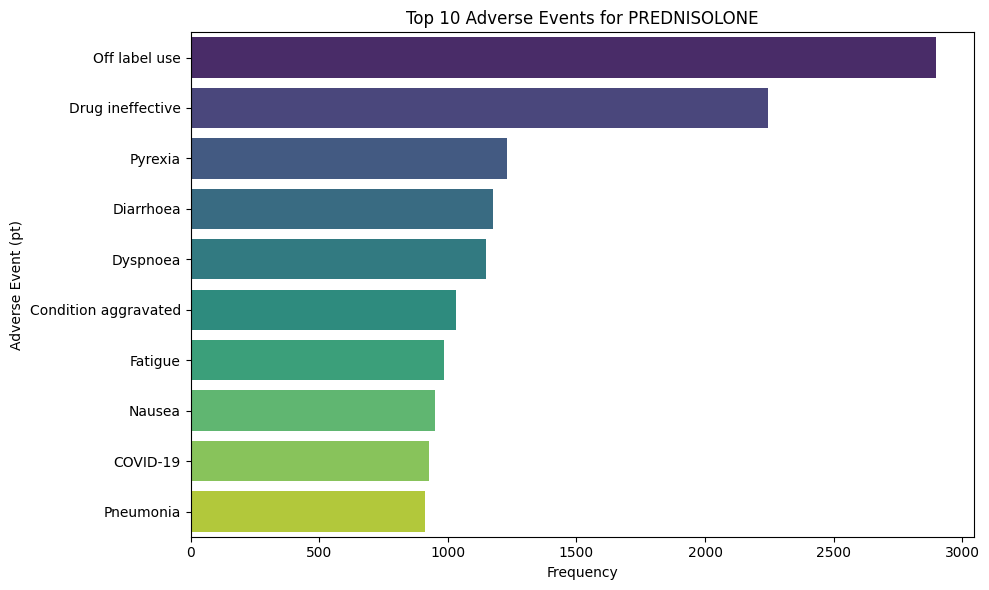

<ipython-input-44-c49c2a3c2940>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_events.values, y=top_events.index, palette="viridis")


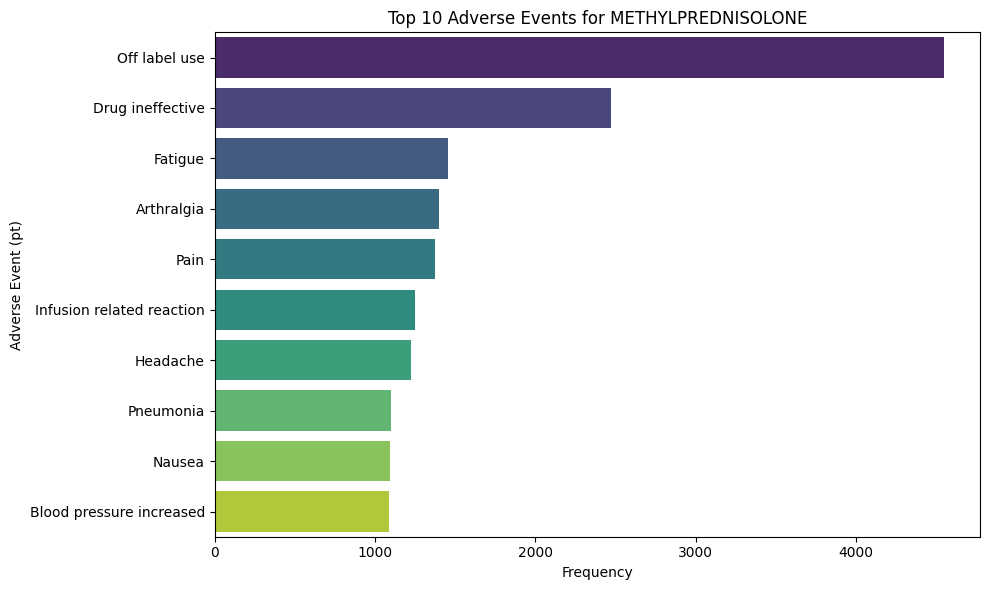

<ipython-input-44-c49c2a3c2940>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_events.values, y=top_events.index, palette="viridis")


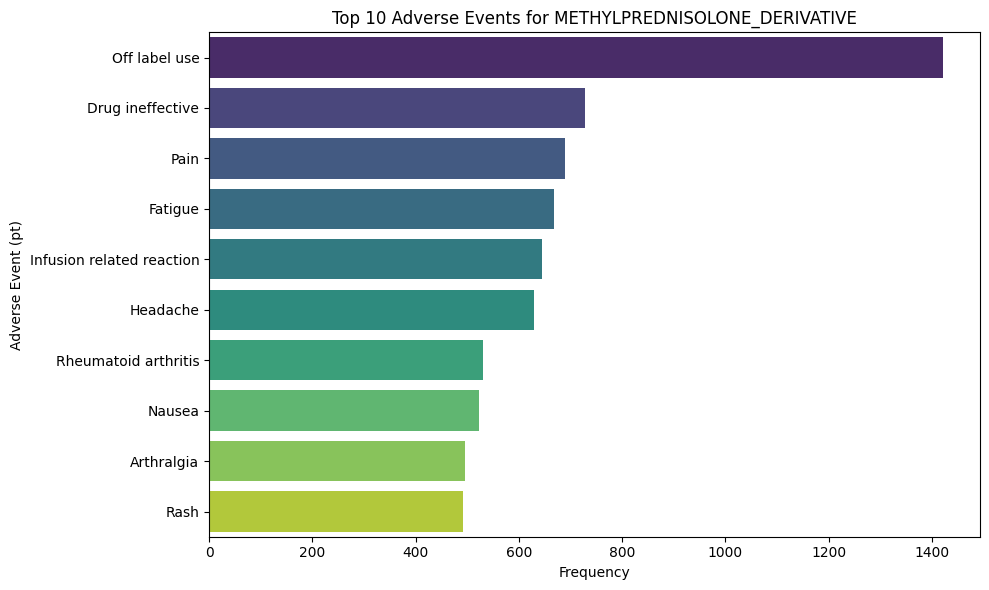

<ipython-input-44-c49c2a3c2940>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_events.values, y=top_events.index, palette="viridis")


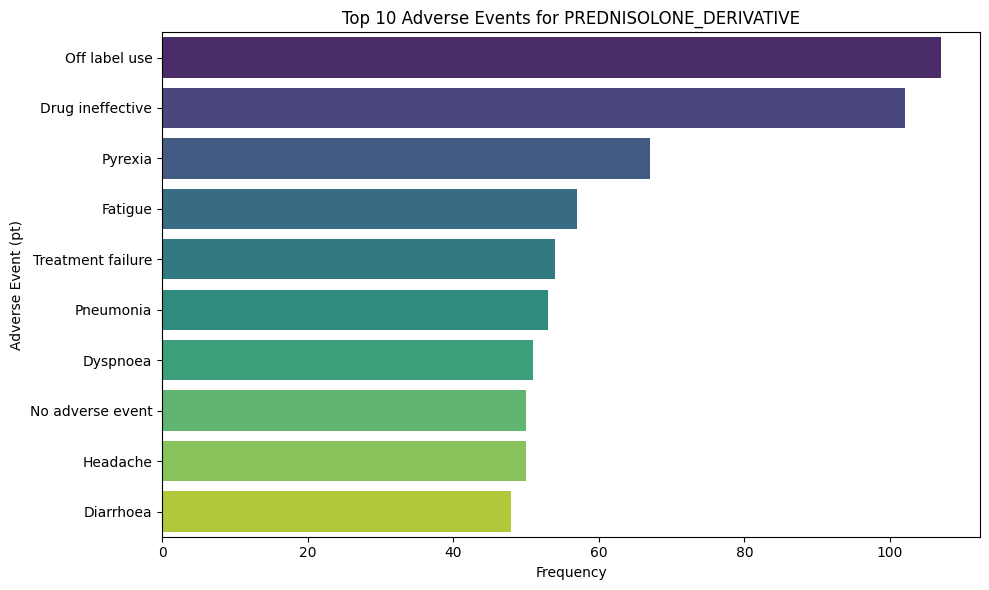

<ipython-input-44-c49c2a3c2940>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_events.values, y=top_events.index, palette="viridis")


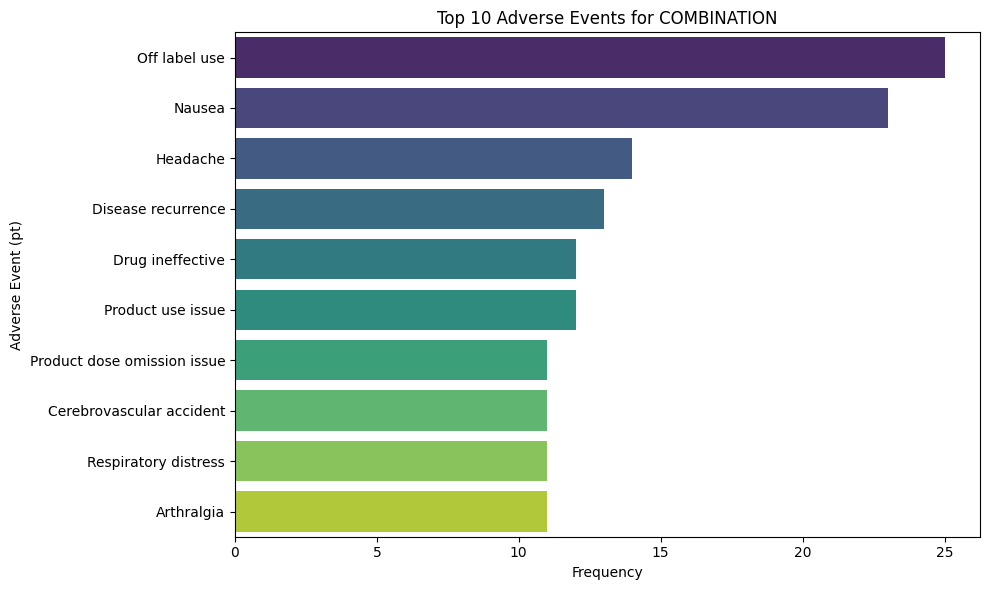

<ipython-input-44-c49c2a3c2940>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='major_class_5cat', y='age', data=final_one_row, palette="Set3")


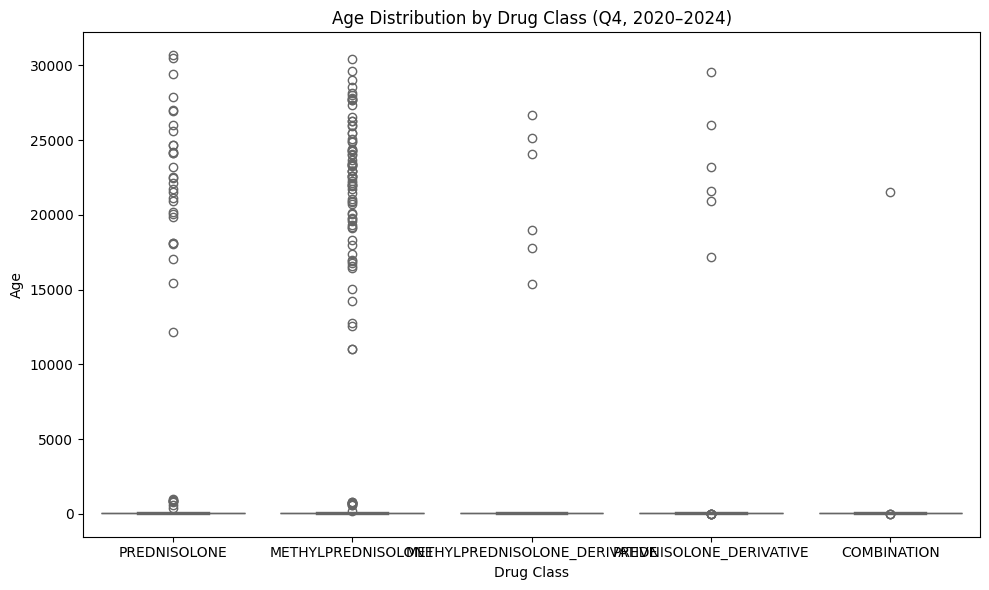

In [ ]:
# Explode the aggregated 'pt' column into individual adverse events

# Create a new column 'pt_list' by splitting the 'pt' string
final_one_row['pt_list'] = final_one_row['pt'].str.split("; ")
# Explode the list so that each adverse event is in a separate row
exploded_df = final_one_row.explode('pt_list')

# Visualization: Top common adverse events by drug class
# Get the unique drug classes (drop any NaN)
drug_classes = final_one_row['major_class_5cat'].dropna().unique()

# For each drug class, compute the top 10 most common adverse events and plot a bar chart
for drug_class in drug_classes:
    df_temp = exploded_df[exploded_df['major_class_5cat'] == drug_class]
    top_events = df_temp['pt_list'].value_counts().head(10)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_events.values, y=top_events.index, palette="viridis")
    plt.title(f"Top 10 Adverse Events for {drug_class}")
    plt.xlabel("Frequency")
    plt.ylabel("Adverse Event (pt)")
    plt.tight_layout()
    plt.show()

# Visualization: Age distribution by drug class
plt.figure(figsize=(10, 6))
sns.boxplot(x='major_class_5cat', y='age', data=final_one_row, palette="Set3")
plt.title("Age Distribution by Drug Class (Q4, 2020–2024)")
plt.xlabel("Drug Class")
plt.ylabel("Age")
plt.tight_layout()
plt.show()


Total unique adverse event terms: 7429
Cluster 0: ['Oral candidiasis', 'Oral herpes', 'Oral pain', 'Mucosal inflammation', 'Mucosal ulceration']
Cluster 1: ['Post transplant lymphoproliferative disorder', 'Obstructive airways disorder', 'Back disorder', 'Bone disorder', 'Musculoskeletal disorder']
Cluster 2: ['Nail injury', 'Limb injury', 'Head injury', 'Hepatocellular injury', 'Superficial injury of eye']
Cluster 3: ['Asthma', 'Death', 'Meningeal neoplasm', 'Meningioma malignant', 'Monoparesis']
Cluster 4: ['Procedural complication', 'Wound dehiscence', 'Wound', 'Sedation complication', 'Wound abscess']
Cluster 5: ['Infection', 'Cytomegalovirus infection', 'Post procedural infection', 'Tooth infection', 'Upper respiratory tract infection']
Cluster 6: ['Red blood cell sedimentation rate increased', 'Gastrointestinal carcinoma', 'Lymphoma', 'Red blood cell sedimentation rate abnormal', 'Basal cell carcinoma']
Cluster 7: ['Acute respiratory distress syndrome', 'Upper-airway cough syndrom

<ipython-input-45-8c11ad5c2713>:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='viridis')


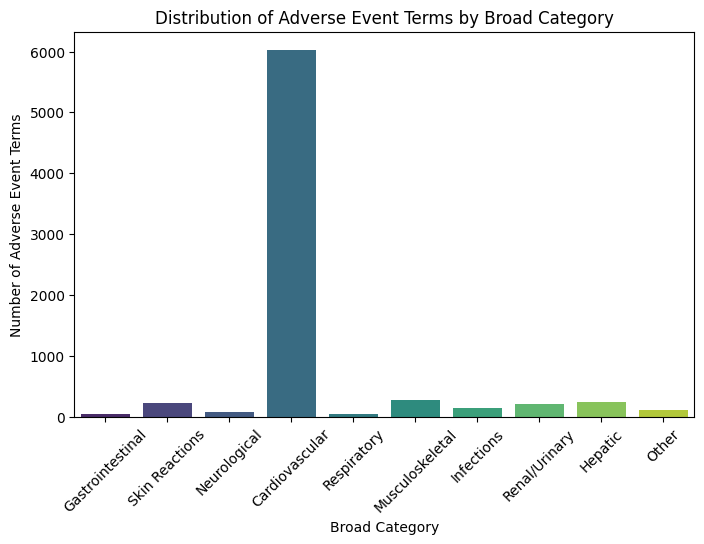

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# Extract all unique adverse event terms from the exploded column in exploded_df.
# Assume exploded_df is already created from your aggregated data and contains a column 'pt_list',
# where each row corresponds to a single adverse event term.
unique_pt_terms = exploded_df['pt_list'].dropna().unique()
unique_pt_terms = list(unique_pt_terms)
print(f"Total unique adverse event terms: {len(unique_pt_terms)}")

# Vectorize the adverse event terms using TF-IDF.
vectorizer = TfidfVectorizer(stop_words='english')
X_pt = vectorizer.fit_transform(unique_pt_terms)

# Use K-Means clustering to group the terms into 10 clusters.
num_clusters = 10
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X_pt)
clusters = kmeans.labels_

# Create a DataFrame mapping each adverse event term to its assigned cluster.
pt_clusters = pd.DataFrame({'pt_term': unique_pt_terms, 'cluster': clusters})

# OPTIONAL: Print the top 5 terms for each cluster for inspection.
for i in range(num_clusters):
    terms = pt_clusters[pt_clusters['cluster'] == i]['pt_term'].head(5).tolist()
    print(f"Cluster {i}: {terms}")

# Manually define a mapping from cluster id to broad category names.
# (Adjust these names based on your domain expertise.)
cluster_labels = {
    0: "Gastrointestinal",
    1: "Skin Reactions",
    2: "Neurological",
    3: "Cardiovascular",
    4: "Respiratory",
    5: "Musculoskeletal",
    6: "Infections",
    7: "Renal/Urinary",
    8: "Hepatic",
    9: "Other"
}

pt_clusters['broad_category'] = pt_clusters['cluster'].map(cluster_labels)
print("Adverse event terms with assigned clusters and broad categories:")
print(pt_clusters.sort_values('cluster').head(20))

# Merge the broad category mapping back into the main exploded DataFrame.
# We match the 'pt_list' from exploded_df with 'pt_term' in pt_clusters.
exploded_df = exploded_df.merge(pt_clusters[['pt_term', 'broad_category']],
                                left_on='pt_list', right_on='pt_term', how='left')
# Optionally, drop the redundant column 'pt_term'
exploded_df.drop(columns=['pt_term'], inplace=True)
print("Updated exploded_df with 'broad_category':")
print(exploded_df.head(10))

# Use the pt_clusters DataFrame for an overall cluster count.
# Map numeric cluster indices to broad category names using the cluster_labels dictionary
cluster_counts.index = cluster_counts.index.map(lambda x: cluster_labels.get(x, str(x)))

plt.figure(figsize=(8, 5))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='viridis')
plt.xlabel("Broad Category")
plt.ylabel("Number of Adverse Event Terms")
plt.title("Distribution of Adverse Event Terms by Broad Category")
plt.xticks(rotation=45)
plt.show()



In [ ]:
# Save final processed data to a CSV file on Google Drive
csv_path = "/content/drive/My Drive/final_processed_data.csv"
final_one_row.to_csv(csv_path, index=False)
print(f"Final processed data has been saved to {csv_path}")


Final processed data has been saved to /content/drive/My Drive/final_processed_data.csv


In [ ]:
final_one_row

,year,quarter,caseid,age,sex,drugname_clean,major_class_5cat,pt,indi_pt,dechal,rechal,age_group,pt_list
0,2020,Q4,6715981,37.0,M,PREDNISOLONE.,PREDNISOLONE,Asthma; Death,Asthma; HIV infection,None,None,35-50,"[Asthma, Death]"
1,2020,Q4,6798099,44.0,M,PREDNISOLONE.,PREDNISOLONE,Meningeal neoplasm; Meningioma malignant; Mono...,Chemotherapy; Immunosuppression; Product used ...,U,None,35-50,"[Meningeal neoplasm, Meningioma malignant, Mon..."
2,2020,Q4,7096069,45.0,M,PREDNISOLONE.,PREDNISOLONE,Gangrene; Haemorrhagic infarction; Hypoalbumin...,Lepromatous leprosy; Product used for unknown ...,U,None,35-50,"[Gangrene, Haemorrhagic infarction, Hypoalbumi..."
3,2020,Q4,7740732,30.0,F,METHYLPREDNISOLONE.,METHYLPREDNISOLONE,Abdominal discomfort; Asthma; Blood pressure i...,Asthma; Product used for unknown indication,U,None,18-35,"[Abdominal discomfort, Asthma, Blood pressure ..."
4,2020,Q4,7796415,64.0,M,METHYLPREDNISOLONE.,METHYLPREDNISOLONE,Hepatotoxicity; Venoocclusive liver disease,Acute myeloid leukaemia; Premedication,None,None,50-65,"[Hepatotoxicity, Venoocclusive liver disease]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
45575,2024,Q4,24795336,67.0,M,PREDNISOLONE,PREDNISOLONE,Cough; Cytomegalovirus infection reactivation;...,Product used for unknown indication,U,None,65+,"[Cough, Cytomegalovirus infection reactivation..."
45576,2024,Q4,24795452,40.0,F,METHYLPREDNISOLONE,METHYLPREDNISOLONE,Abdominal discomfort; Abdominal distension; Ab...,Migraine; Product used for unknown indication;...,U,None,35-50,"[Abdominal discomfort, Abdominal distension, A..."
45577,2024,Q4,24795481,40.0,F,METHYLPREDNISOLONE SODIUM SUCCINATE,METHYLPREDNISOLONE_DERIVATIVE,C-reactive protein abnormal; C-reactive protei...,Migraine; Product used for unknown indication;...,D,None,35-50,"[C-reactive protein abnormal, C-reactive prote..."
45578,2024,Q4,24795517,84.0,M,PREDNISOLONE,PREDNISOLONE,Off label use; Pulmonary embolism,Immune thrombocytopenia,None,None,65+,"[Off label use, Pulmonary embolism]"
